<a href="https://colab.research.google.com/github/LANZhengyang/Bayesian-Learning-via-SGLD/blob/main/notebook/Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
 
%matplotlib inline
 
import pandas as pd
 
import matplotlib.pyplot as plt
import torch
import math
 
from torch.distributions.normal import Normal

# Introduction
This notebook will show the implementation of Stochastic Gradient Langevin Dynamics on Linear regression.

## Sample and display the train data

Text(0, 0.5, 'y')

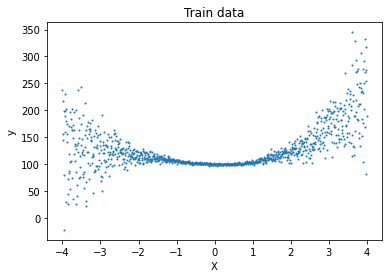

In [2]:


N=1000

a_star = torch.distributions.normal.Normal(100, 1).sample(sample_shape=torch.Size([N]))
b_star = torch.distributions.normal.Normal(-2, 1).sample(sample_shape=torch.Size([N]))
c_star = torch.distributions.normal.Normal(5, 1).sample(sample_shape=torch.Size([N]))
d_star = torch.distributions.normal.Normal(1, 1).sample(sample_shape=torch.Size([N]))


x = torch.linspace(-4.0, 4, N)
y = a_star + b_star * x + c_star* x ** 2 + d_star* x ** 3 

plt.scatter(x.numpy(),y.squeeze().numpy(),s=1)

plt.title('Train data')
plt.xlabel('X')
plt.ylabel('y')

## Start Stochastic Gradient Langevin Dynamics algorithm

In [3]:
# hyperparameter set

batch_size=100
a0=8e-5
b0=1000
gamma=0.55


# init parameter
a = torch.randn((), requires_grad=True)
b = torch.randn((), requires_grad=True)
c = torch.randn((), requires_grad=True)
d = torch.randn((), requires_grad=True)

injected_noise_v = []
Vs = []

Vs1 = []
Vs2 = []
Vs3 = []
Vs4 = []


samples = []

for t in range(10000):
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    learning_rate = a0 *(b0+t)**(-gamma)

    # # sample batch data from all data
    sample_index = torch.randperm(len(y))[:batch_size]
    batch_y = y[sample_index]
    batch_x = x[sample_index]
    


    pos = -(N/batch_size)*sum((batch_y-(a+batch_x*b+c*(batch_x**2)+d*(batch_x**3)))**2) # posterior
    
    p = torch.distributions.normal.Normal(0, 1) # proir

    ((p.log_prob(a) + p.log_prob(b) + p.log_prob(c) + p.log_prob(d) + pos)).backward()

    if t % 1000 == 0:
        print('iteration',t,'learning rate',learning_rate)
        print(sum((y-y_pred)**2))

    # updata parameter
    with torch.no_grad():
        a += learning_rate * a.grad + Normal(0, learning_rate).sample()
        b += learning_rate * b.grad+ Normal(0, learning_rate).sample()
        c += learning_rate * c.grad+ Normal(0, learning_rate).sample()
        d += learning_rate * d.grad  + Normal(0, learning_rate).sample()

        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None
        
    # sampling at all iteration (select later)
    samples.append(torch.distributions.normal.Normal(a, 1).sample() +
                   torch.distributions.normal.Normal(b, 1).sample() *x+
                   torch.distributions.normal.Normal(c, 1).sample() *x**2+
                   torch.distributions.normal.Normal(d, 1).sample() *x**3)
    
    # save Vs and learning rate  
    st = []
    for i in range(len(batch_y)):
        ((1/N)*p.log_prob(a)+((1/2)*(batch_y-(a+batch_x*b+c*(batch_x**2)+d*(batch_x**3)))**2)[i]).backward()
        with torch.no_grad():
        
            st.append((a.grad.numpy()))
            a.grad = None
        
    Vs1.append(np.var(np.array(st)))


    st = []
    for i in range(len(batch_y)):
        ((1/N)*p.log_prob(b)+((batch_y-(a+batch_x*b+c*(batch_x**2)+d*(batch_x**3)))**2)[i]).backward()
        with torch.no_grad():
        
            st.append((b.grad.numpy()))
            b.grad = None
        
    Vs2.append(np.var(np.array(st)))


    st = []
    for i in range(len(batch_y)):
        ((1/N)*p.log_prob(c)+((batch_y-(a+batch_x*b+c*(batch_x**2)+d*(batch_x**3)))**2)[i]).backward()
        with torch.no_grad():
        
            st.append((c.grad.numpy()))
            c.grad = None
        
    Vs3.append(np.var(np.array(st)))


    st = []
    for i in range(len(batch_y)):
        ((1/N)*p.log_prob(d)+((batch_y-(a+batch_x*b+c*(batch_x**2)+d*(batch_x**3)))**2)[i]).backward()
        with torch.no_grad():
        
            st.append((d.grad.numpy()))
            d.grad = None
        
    Vs4.append(np.var(np.array(st)))
    
    injected_noise_v.append(learning_rate)

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')


iteration 0 learning rate 1.7909769108546713e-06
tensor(19221802., grad_fn=<AddBackward0>)
iteration 1000 learning rate 1.2232732795725546e-06
tensor(1852792.8750, grad_fn=<AddBackward0>)
iteration 2000 learning rate 9.787534296863324e-07
tensor(1169836.2500, grad_fn=<AddBackward0>)
iteration 3000 learning rate 8.355202724540419e-07
tensor(822094.6875, grad_fn=<AddBackward0>)
iteration 4000 learning rate 7.390204982442297e-07
tensor(721605.2500, grad_fn=<AddBackward0>)
iteration 5000 learning rate 6.685082931939813e-07
tensor(721619.6250, grad_fn=<AddBackward0>)
iteration 6000 learning rate 6.141664166026413e-07
tensor(708506.3125, grad_fn=<AddBackward0>)
iteration 7000 learning rate 5.706771637533109e-07
tensor(701407.6875, grad_fn=<AddBackward0>)
iteration 8000 learning rate 5.348803048865723e-07
tensor(703183.6875, grad_fn=<AddBackward0>)
iteration 9000 learning rate 5.047658755841545e-07
tensor(733296.2500, grad_fn=<AddBackward0>)
Result: y = 98.62602996826172 + -1.0078407526016235

## Variance of SG noise and injected noise

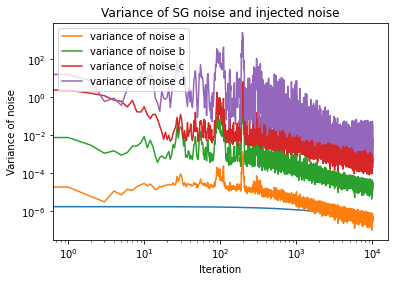

In [8]:
n=batch_size
plt.plot(range(len(injected_noise_v)),(injected_noise_v))
plt.xscale("log")
plt.yscale("log")

plt.plot(np.array(N**2/n)*Vs1*(np.array(injected_noise_v)/2)**2,label="variance of noise a")
plt.plot(np.array(N**2/n)*Vs2*(np.array(injected_noise_v)/2)**2,label="variance of noise b")
plt.plot(np.array(N**2/n)*Vs3*(np.array(injected_noise_v)/2)**2,label="variance of noise c")
plt.plot(np.array(N**2/n)*Vs4*(np.array(injected_noise_v)/2)**2,label="variance of noise d")

plt.title('Variance of SG noise and injected noise')
plt.xlabel('Iteration')
plt.ylabel('Variance of noise')
plt.legend()

## All sample curve

Text(0.5, 1.0, 'All sample curve')

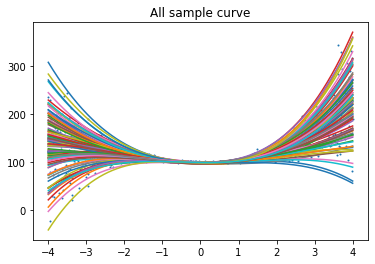

In [5]:
ar_sample = [np.array(i) for i in samples]
ar_sample = ar_sample[-100:]

plt.scatter(x.numpy(),y.squeeze().numpy(),s=1)

for i in ar_sample:
    plt.plot(np.linspace(-4,4,N),i)
plt.title('All sample curve')

## Mean of sample curve with 1 and 2 standard deviation lines

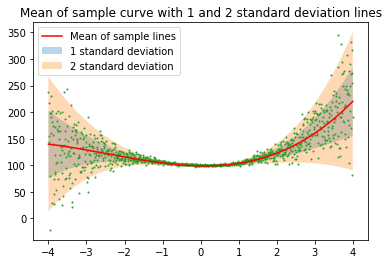

In [6]:
plt.plot(np.linspace(-4,4,N),np.mean(ar_sample,axis=0),color='r',label="Mean of sample lines")

plt.fill_between(np.linspace(-4,4,N), np.mean(ar_sample,axis=0) - np.std(ar_sample,axis=0), np.mean(ar_sample,axis=0) + np.std(ar_sample,axis=0),alpha=0.3,label="1 standard deviation")
plt.fill_between(np.linspace(-4,4,N), np.mean(ar_sample,axis=0) - np.std(ar_sample,axis=0)*2, np.mean(ar_sample,axis=0) + np.std(ar_sample,axis=0)*2,alpha=0.3,label="2 standard deviation")

plt.scatter(x.numpy(),y.squeeze().numpy(),s=1)
plt.title('Mean of sample curve with 1 and 2 standard deviation lines')
plt.legend()